In [1]:
import math
import numpy as np
import pandas as pd
import torch
import gpytorch as gp
from torch.quasirandom import SobolEngine
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2]:
lda = pd.read_csv("lda.csv")

D_df = lda.sample(n=32)

X = torch.tensor(D_df[["kappa", "tau", "s"]].values)
y = torch.tensor(D_df["value"].values)
X_test = torch.tensor(lda[["kappa", "tau", "s"]].values)
y_test = torch.tensor(lda["value"].values)

print(X.shape)
print(y.shape)
print(X_test.shape)
print(y_test.shape)

torch.Size([32, 3])
torch.Size([32])
torch.Size([289, 3])
torch.Size([289])


# Data Visualization

<AxesSubplot:xlabel='value', ylabel='Density'>

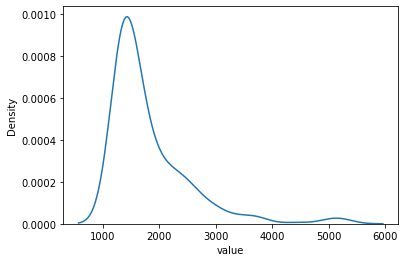

In [3]:
values = lda['value']
sns.kdeplot(values)

<AxesSubplot:xlabel='value', ylabel='Density'>

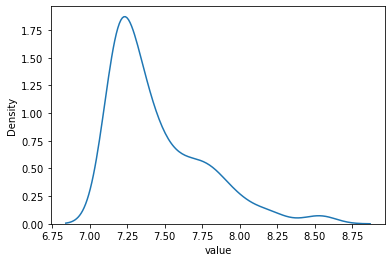

In [4]:
sns.kdeplot(np.log(values))

<AxesSubplot:xlabel='value', ylabel='Density'>

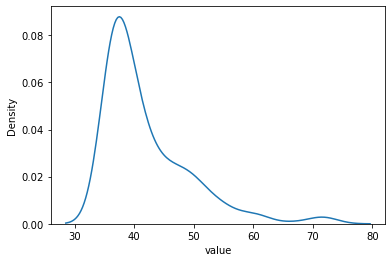

In [5]:
sns.kdeplot(np.sqrt(values))

<AxesSubplot:xlabel='value', ylabel='Density'>

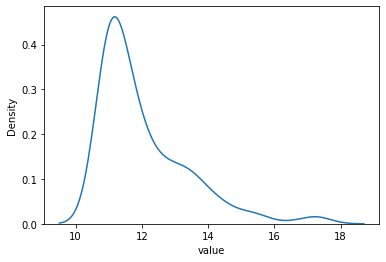

In [6]:
sns.kdeplot(np.cbrt(values))

# Model Fitting

In [7]:
class prior(gp.models.ExactGP):
    def __init__(self, train_inputs, train_targets, likelihood, kernel):
        super().__init__(train_inputs, train_targets, likelihood)
        self.mean_module = gp.means.ConstantMean()
        self.covar_module = kernel
    
    def forward(self, x):
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return gp.distributions.MultivariateNormal(mean, covar)

def bic(theta, D, mll):
    ans = theta*math.log(D)
    ans -= 2*mll
    return ans

In [8]:
y = np.cbrt(y)
y_test = np.cbrt(y_test)

k0 = gp.kernels.ScaleKernel(gp.kernels.MaternKernel(nu=2.5))
k1 = gp.kernels.ScaleKernel(gp.kernels.MaternKernel(nu=1.5))
k2 = gp.kernels.ScaleKernel(gp.kernels.RBFKernel())
k3 = gp.kernels.ScaleKernel(gp.kernels.MaternKernel(nu=2.5, ard_num_dims=3))
k4 = gp.kernels.ScaleKernel(gp.kernels.MaternKernel(nu=1.5, ard_num_dims=3))
k5 = gp.kernels.ScaleKernel(gp.kernels.RBFKernel(ard_num_dims=3))
k6 = gp.kernels.SpectralMixtureKernel(num_mixtures=3, ard_num_dims=3)

kernels = [k0, k1, k2, k3, k4, k5, k6]
thetas = [3, 3, 3, 5, 5, 5, 22]

for i in range(7):
    likelihood = gp.likelihoods.FixedNoiseGaussianLikelihood(torch.ones(32)*(0.01**2))
    model = prior(X, y, likelihood, kernels[i])
    training_iter = 1000

    model.train()
    likelihood.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=.01)
    mll = gp.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for j in range(training_iter):
        optimizer.zero_grad()
        output = model(X)
        loss = -mll(output, y)
        loss.backward()
        optimizer.step()
        
    with gp.settings.fast_computations(covar_root_decomposition=False, log_prob=False, solves=False):
        print("BIC {} : {}".format(i, bic(thetas[i], 32, mll(model(X), y))))

BIC 0 : 22.50241595696704
BIC 1 : 22.410478377861853
BIC 2 : 22.68165384581755
BIC 3 : 28.521098563664538
BIC 4 : 28.466931893335904
BIC 5 : 28.83891214449922
BIC 6 : 81.25419835613397


In [9]:
k0 = gp.kernels.ScaleKernel(gp.kernels.MaternKernel(nu=2.5))
k1 = gp.kernels.ScaleKernel(gp.kernels.MaternKernel(nu=1.5))
k2 = gp.kernels.ScaleKernel(gp.kernels.RBFKernel())
k3 = gp.kernels.ScaleKernel(gp.kernels.MaternKernel(nu=2.5, ard_num_dims=3))
k4 = gp.kernels.ScaleKernel(gp.kernels.MaternKernel(nu=1.5, ard_num_dims=3))
k5 = gp.kernels.ScaleKernel(gp.kernels.RBFKernel(ard_num_dims=3))
k6 = gp.kernels.SpectralMixtureKernel(num_mixtures=3, ard_num_dims=3)

base_kernel_names = ["M2.5", "M1.5", "SE", "M2.5_ARD", "M1.5_ARD", "SE_ARD"]
base_kernels = [k0, k1, k2, k3, k4, k5]
kernel_names = ["M2.5", "M1.5", "SE", "M2.5_ARD", "M1.5_ARD", "SE_ARD"]
kernels = [k0, k1, k2, k3, k4, k5]
base_thetas = [3, 3, 3, 5, 5, 5]
thetas = [3, 3, 3, 5, 5, 5]
bics = np.zeros(6)
mlls = np.zeros(6)

best_kernel = None
best_kernel_name = None
best_bic = float("inf")

num_runs = 5
for run in range(num_runs):
    for i in range(len(kernels)):
        likelihood = gp.likelihoods.FixedNoiseGaussianLikelihood(torch.ones(32)*(0.01**2))
        model = prior(X, y, likelihood, kernels[i])
        training_iter = 1000

        model.train()
        likelihood.train()
        optimizer = torch.optim.Adam(model.parameters(), lr=.01)
        mll = gp.mlls.ExactMarginalLogLikelihood(likelihood, model)

        for j in range(training_iter):
            optimizer.zero_grad()
            output = model(X)
            loss = -mll(output, y)
            loss.backward()
            optimizer.step()
        with gp.settings.fast_computations(covar_root_decomposition=False, log_prob=False, solves=False):
            bics[i] = bic(thetas[i], 32, mll(model(X), y))
            mlls[i] = mll(model(X), y)

    best_idx = np.argmin(bics)
    best_k_cur = kernels[best_idx]
    best_bic_cur = bics[best_idx]
    best_mll_cur = mlls[best_idx]
    best_theta_cur = thetas[best_idx]
    best_kernel_name_cur = kernel_names[best_idx]

    if best_bic_cur < best_bic:
        best_kernel = best_k_cur
        best_bic = best_bic_cur
        best_kernel_name = best_kernel_name_cur

    kernels = [None for _ in range(12)]
    thetas = [None for _ in range(12)]
    kernel_names = [None for _ in range(12)]
    bics = np.zeros(12)
    mlls = np.zeros(12)
    for i in range(len(base_kernels)):
        kernels[i] = best_k_cur + base_kernels[i]
        thetas[i] = best_theta_cur + base_thetas[i]
        kernel_names[i] = best_kernel_name_cur + " + " + base_kernel_names[i]
        kernels[i+6] = best_k_cur * base_kernels[i]
        thetas[i+6] = best_theta_cur + base_thetas[i]
        kernel_names[i+6] = best_kernel_name_cur + " * " + base_kernel_names[i]
    
    print("Run {}".format(run+1))
    print(best_kernel_name_cur)
    print(best_bic_cur)
    print(np.exp(best_mll_cur))
    print(kernel_names)
    print(thetas)
    print()

print(best_kernel_name)
print(best_bic)

Run 1
M1.5
22.410478377861853
0.0024623592726060422
['M1.5 + M2.5', 'M1.5 + M1.5', 'M1.5 + SE', 'M1.5 + M2.5_ARD', 'M1.5 + M1.5_ARD', 'M1.5 + SE_ARD', 'M1.5 * M2.5', 'M1.5 * M1.5', 'M1.5 * SE', 'M1.5 * M2.5_ARD', 'M1.5 * M1.5_ARD', 'M1.5 * SE_ARD']
[6, 6, 6, 8, 8, 8, 6, 6, 6, 8, 8, 8]

Run 2
M1.5 * SE
23.61922716532939
0.24355661112395116
['M1.5 * SE + M2.5', 'M1.5 * SE + M1.5', 'M1.5 * SE + SE', 'M1.5 * SE + M2.5_ARD', 'M1.5 * SE + M1.5_ARD', 'M1.5 * SE + SE_ARD', 'M1.5 * SE * M2.5', 'M1.5 * SE * M1.5', 'M1.5 * SE * SE', 'M1.5 * SE * M2.5_ARD', 'M1.5 * SE * M1.5_ARD', 'M1.5 * SE * SE_ARD']
[9, 9, 9, 11, 11, 11, 9, 9, 9, 11, 11, 11]

Run 3
M1.5 * SE + M1.5
35.424336718322856
0.12046972570707429
['M1.5 * SE + M1.5 + M2.5', 'M1.5 * SE + M1.5 + M1.5', 'M1.5 * SE + M1.5 + SE', 'M1.5 * SE + M1.5 + M2.5_ARD', 'M1.5 * SE + M1.5 + M1.5_ARD', 'M1.5 * SE + M1.5 + SE_ARD', 'M1.5 * SE + M1.5 * M2.5', 'M1.5 * SE + M1.5 * M1.5', 'M1.5 * SE + M1.5 * SE', 'M1.5 * SE + M1.5 * M2.5_ARD', 'M1.5 * SE + M1

In [10]:
likelihood = gp.likelihoods.FixedNoiseGaussianLikelihood(torch.ones(32)*(0.01**2))
k = gp.kernels.ScaleKernel(gp.kernels.MaternKernel(nu=1.5))
model = prior(X, y, likelihood, k)
training_iter = 1000

model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=.1)
mll = gp.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(X)
    loss = -mll(output, y)
    loss.backward()
    optimizer.step()

print("Final Hyperparmeters - Marginal Log Likelihood: {:.4e}   outputscale: {:.4f}   lengthscale: {:.4f}   mean: {:.4f}".format(
    mll(model(X), y),
    model.covar_module.outputscale.item(),
    model.covar_module.base_kernel.lengthscale.item(),
    model.mean_module.constant[0]
  ))
with gp.settings.fast_computations(covar_root_decomposition=False, log_prob=False, solves=False):
    print("BIC {} : {}".format(i, bic(3, 32, mll(model(X), y))))

Final Hyperparmeters - Marginal Log Likelihood: -1.4640e+00   outputscale: 4.1435   lengthscale: 1.2122   mean: 12.3929
BIC 999 : 13.325184990317569
